## GP Training

This notebook demonstrates how to train a Gaussian process surrogate model using `alabi` and visualize the results.

In [1]:
%matplotlib inline
import numpy as np
from alabi import SurrogateModel

### Define a Test Problem: Rosenbrock Function

We'll use the 2D Rosenbrock function as our test case. This is a common benchmark function for optimization and sampling algorithms.

In [2]:
from scipy.optimize import rosen

def rosenbrock_fn(x):
    return -rosen(x)/100.0

bounds = [(-5,5), (-5,5)]
param_names = ['x1', 'x2']


### Create and Train Surrogate Model

First, we'll create a Gaussian Process surrogate model and train it using active learning.

In [3]:
# Initialize the surrogate model
sm = SurrogateModel(
    lnlike_fn=rosenbrock_fn,
    bounds=bounds,
    savedir="results/rosenbrock_2d",
    cache=True,
    verbose=True,
    ncore=4
)

# Compute initial training samples (parallelized if ncore > 1)
sm.init_samples(ntrain=100, ntest=1000, sampler="sobol")

Computed 100 function evaluations: 0.0s 

Computed 1000 function evaluations: 0.0s 



In [4]:
# Initialize the Gaussian Process with specified hyperparameters
gp_kwargs = {"kernel": "ExpSquaredKernel", 
             "fit_amp": True, 
             "fit_mean": True, 
             "fit_white_noise": False, 
             "white_noise": -12,
             "gp_opt_method": "l-bfgs-b",
             "gp_scale_rng": [-2,2],
             "optimizer_kwargs": {"max_iter": 50}}

sm.init_gp(**gp_kwargs)

Initialized GP with squared exponential kernel.
Optimized 4 hyperparameters: (0.102s)


In [5]:
al_kwargs={"algorithm": "bape", 
           "gp_opt_freq": 20, 
           "obj_opt_method": "nelder-mead", 
           "use_grad_opt": True,
           "nopt": 1,
           "optimizer_kwargs": {"max_iter": 50, "xatol": 1e-3, "fatol": 1e-2, "adaptive": True}}

sm.active_train(niter=100, **al_kwargs)

Running 100 active learning iterations using bape...


  0%|          | 0/100 [00:00<?, ?it/s]

 20%|██        | 20/100 [00:02<00:12,  6.57it/s]

Optimized 4 hyperparameters: (0.132s)


 40%|████      | 40/100 [00:05<00:12,  4.78it/s]

Optimized 4 hyperparameters: (0.095s)


 60%|██████    | 60/100 [00:08<00:06,  5.92it/s]

Optimized 4 hyperparameters: (0.09s)


 80%|████████  | 80/100 [00:12<00:04,  4.61it/s]

Optimized 4 hyperparameters: (0.106s)


100%|██████████| 100/100 [00:15<00:00,  6.29it/s]

Optimized 4 hyperparameters: (0.205s)
Caching model to results/rosenbrock_2d/surrogate_model...


Now you can use the trained GP surrogate model by calling the function `sm.surrogate_log_likelihood(theta)`

In [6]:
theta_test = np.array([0.0, 0.0])

ytrue = sm.true_log_likelihood(theta_test)
ysurrogate = sm.surrogate_log_likelihood(theta_test)

print(f"True log-likelihood at {theta_test}: {ytrue}")
print(f"Surrogate log-likelihood at {theta_test}: {ysurrogate}")

True log-likelihood at [0. 0.]: -0.01
Surrogate log-likelihood at [0. 0.]: -0.019423397984130675


### Visualize the Surrogate Model

Let's plot the surrogate model to see how well it captures the true function.

Plotting true function contours 2D...
Saving to  results/rosenbrock_2d/true_function_2D.png


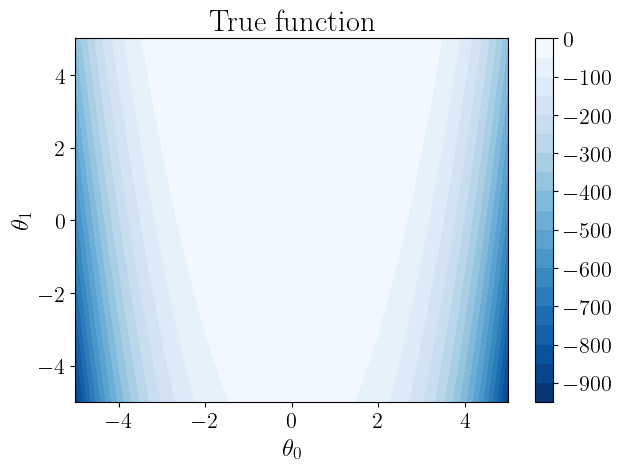

In [7]:
sm.plot(plots=["true_fn_2D"])

Plotting gp fit 2D...
Saving to  results/rosenbrock_2d/gp_fit_2D.png


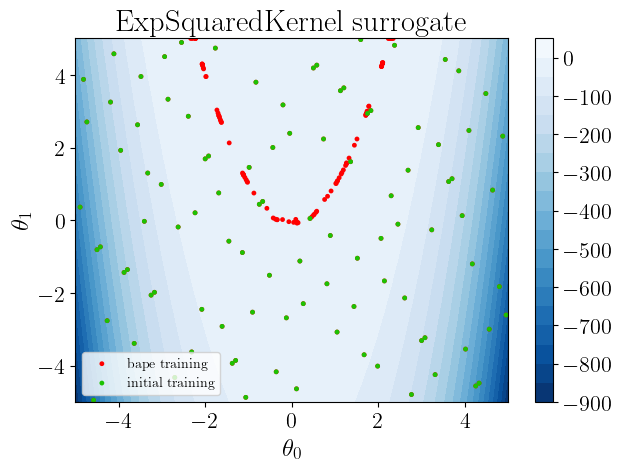

In [8]:
sm.plot(plots=["gp_fit_2D"])

We can also check how the active learning function looks at this iteration. If the model is closed to converged, we expect the high probability regions to be close to 0.

Plotting objective function contours 2D...
Saving to  results/rosenbrock_2d/objective_function.png


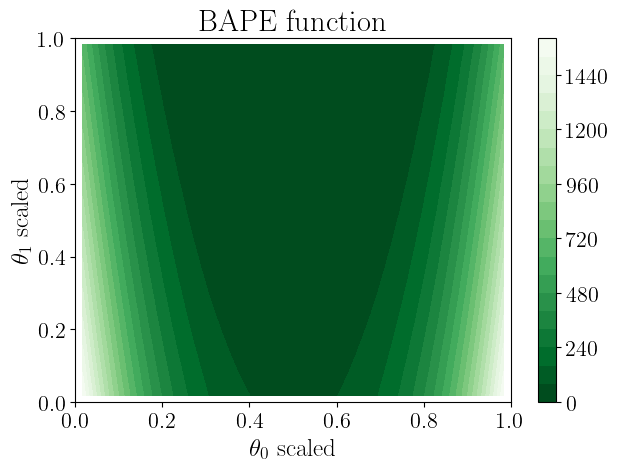

In [9]:
sm.plot(plots=["obj_fn_2D"])

`alabi` also tracks various performance metrics as a function of active learning iteration. These results can be accessed from the dictionary:

In [10]:
sm.training_results.keys()

dict_keys(['iteration', 'gp_hyperparameters', 'gp_hyperparameter_opt_iteration', 'gp_hyperparam_opt_time', 'training_mse', 'test_mse', 'training_scaled_mse', 'test_scaled_mse', 'gp_kl_divergence', 'gp_train_time', 'obj_fn_opt_time'])

Here are some examples of quick plots you can make of these results:

Plotting gp hyperparameters...
Saving to  results/rosenbrock_2d/gp_hyperparameters_vs_iteration.png


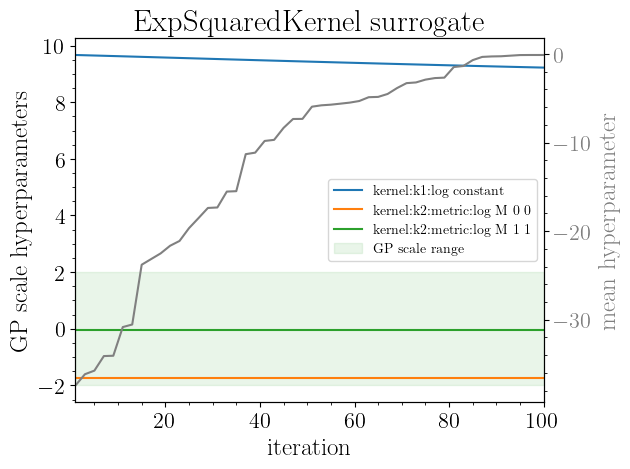

In [11]:
sm.plot(plots=["gp_hyperparameters"])

Plotting the gp mean squared error with 1000 test samples...
Saving to results/rosenbrock_2d/gp_mse_vs_iteration.png


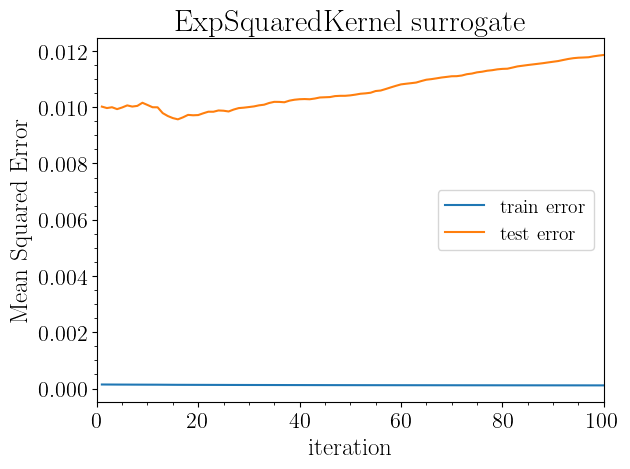

In [12]:
sm.plot(plots=["test_mse"])

Plotting the scaled gp mean squared error with 1000 test samples...
Saving to results/rosenbrock_2d/gp_scaled_mse_vs_iteration.png


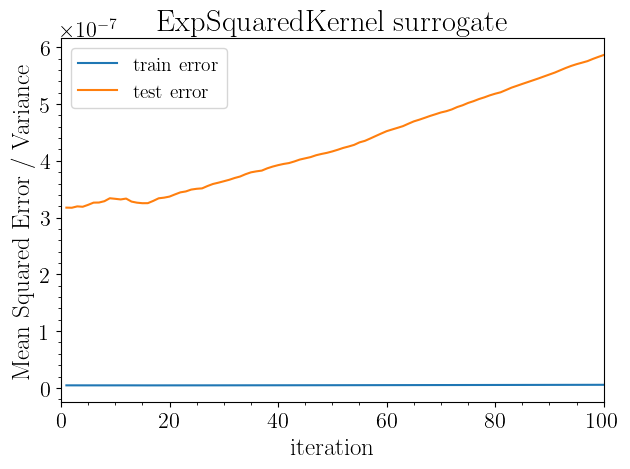

In [13]:
sm.plot(plots=["test_scaled_mse"])